In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import combinators
import smc
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
trajectory = torch.Tensor([[ 1.50143442,  8.55096856],
       [ 1.06017349,  8.64466408],
       [ 1.65819751, 10.1122233 ],
       [ 1.71562382, 10.76197245],
       [ 3.06315849, 10.55134698],
       [ 4.02235515,  9.94670678],
       [ 4.17605964,  9.27495353],
       [ 4.83620658,  9.78387096],
       [ 5.39079787, 10.48605417],
       [ 7.4183912 ,  9.85047259],
       [ 8.30845356, 10.8494063 ],
       [ 8.12459213, 13.16731557],
       [ 8.64493123, 14.24599824],
       [10.47918307, 15.25121641],
       [10.07510105, 14.57959311],
       [10.83873083, 15.57718595],
       [10.49815519, 14.80804265],
       [12.00806874, 15.01008431],
       [12.1389334 , 17.6339842 ],
       [12.62211701, 18.58804524],
       [14.9360797 , 19.75082637],
       [15.16576253, 17.6903859 ],
       [16.65829066, 19.19294766],
       [14.11013264, 19.44405564],
       [15.19715369, 19.71684501],
       [16.1504691 , 18.80454532],
       [17.22036756, 18.95951929],
       [17.59627946, 19.56267278],
       [17.5710769 , 20.24839572],
       [18.64267461, 19.83059014],
       [17.69296912, 20.85112989],
       [18.2373505 , 21.9916041 ],
       [18.65652233, 22.51596093],
       [19.05008756, 23.66721902],
       [19.15276786, 24.40552608],
       [20.39189416, 23.79974421],
       [21.46959649, 23.79121745],
       [21.82385255, 23.99719507],
       [21.88530914, 25.81605932],
       [19.38831002, 27.64266316],
       [20.71551032, 28.24379777],
       [21.25044673, 27.90462808],
       [21.57183137, 28.46909683],
       [21.34828503, 27.73006667],
       [20.92780773, 29.99743856],
       [23.31472253, 30.83324069],
       [21.85322758, 31.91925438],
       [23.80852515, 33.00538403],
       [22.99451885, 32.55574826],
       [23.59435363, 32.42005162],
       [24.03956641, 31.72043475],
       [24.00924889, 32.82206833],
       [24.09196269, 34.46790487],
       [25.09524211, 35.97052848],
       [26.16651995, 37.49622828],
       [25.83977894, 40.41496862],
       [26.67568888, 42.72443504],
       [27.01391463, 44.83547148],
       [28.39224501, 43.96474996],
       [27.65619635, 44.57792917],
       [28.69909113, 44.80968409],
       [27.89316153, 43.38495867],
       [28.58641857, 44.61147894],
       [29.16119525, 45.52323907],
       [27.80686902, 46.00531793],
       [28.19223534, 47.979787  ],
       [27.0006378 , 49.25938313],
       [27.73582183, 50.32008633],
       [28.83134928, 51.72303941],
       [28.6287409 , 52.14179485],
       [29.58553038, 53.87575877],
       [30.24822193, 54.27083156],
       [31.08197733, 54.78558615],
       [30.80322833, 56.3976692 ],
       [31.40326532, 56.77115244],
       [29.92219656, 56.57535323],
       [29.46411245, 57.69290329],
       [28.27725945, 57.75097858],
       [29.1896087 , 57.82208054],
       [30.60172109, 58.87953196],
       [31.78848134, 60.23772431],
       [31.40133689, 61.52129213],
       [32.28759934, 60.51982151],
       [32.21064746, 60.76207375],
       [34.08836002, 60.8162174 ],
       [34.88285177, 59.66617918],
       [34.69316328, 59.8892242 ],
       [35.52563887, 59.148166  ],
       [36.02292441, 58.82879124],
       [37.10755923, 59.89779288],
       [38.09891279, 61.28621417],
       [38.18575013, 60.27811079],
       [39.81203603, 62.62546508],
       [39.73752367, 63.30854243],
       [37.9641175 , 64.37770007],
       [37.76789633, 65.02450348],
       [37.86552643, 64.97460651],
       [37.15316919, 65.29127292],
       [38.37123046, 65.00327917],
       [40.58906757, 65.91082252],
       [41.46604582, 67.70556049]])

displacements = trajectory[1:, :] - trajectory[:-1, :]

generative = {}

for i, point in enumerate(trajectory):
    generative['position_%d' % i] = torch.Tensor(point)
    if i >= 1:
        generative['displacement_%d' % i] = displacements[i-1]

In [4]:
generative

{'position_0': tensor([ 1.5014,  8.5510]),
 'position_1': tensor([ 1.0602,  8.6447]),
 'displacement_1': tensor([-0.4413,  0.0937]),
 'position_2': tensor([  1.6582,  10.1122]),
 'displacement_2': tensor([ 0.5980,  1.4676]),
 'position_3': tensor([  1.7156,  10.7620]),
 'displacement_3': tensor([ 0.0574,  0.6497]),
 'position_4': tensor([  3.0632,  10.5513]),
 'displacement_4': tensor([ 1.3475, -0.2106]),
 'position_5': tensor([ 4.0224,  9.9467]),
 'displacement_5': tensor([ 0.9592, -0.6046]),
 'position_6': tensor([ 4.1761,  9.2750]),
 'displacement_6': tensor([ 0.1537, -0.6718]),
 'position_7': tensor([ 4.8362,  9.7839]),
 'displacement_7': tensor([ 0.6601,  0.5089]),
 'position_8': tensor([  5.3908,  10.4861]),
 'displacement_8': tensor([ 0.5546,  0.7022]),
 'position_9': tensor([ 7.4184,  9.8505]),
 'displacement_9': tensor([ 2.0276, -0.6356]),
 'position_10': tensor([  8.3085,  10.8494]),
 'displacement_10': tensor([ 0.8901,  0.9989]),
 'position_11': tensor([  8.1246,  13.1673]),

In [5]:
num_particles = 500

In [6]:
bouncing_ball_step = combinators.Model(bouncing_ball.bouncing_ball_step,{}, {
    'delta_t': torch.ones(1),
    'directions': torch.Tensor([[1, 1], [-1, 1], [1, -1], [-1, -1]]),
})

In [7]:
init_bouncing_ball = combinators.Model(bouncing_ball.init_bouncing_ball, {
    'position_0': {
        'loc': torch.rand(2) * 10,
        'scale': torch.ones(2),
    },
    'speed': {
        'loc': torch.zeros(1),
        'scale': torch.ones(1),
    },
    'doubt': {
        'loc': torch.zeros(1),
        'scale': torch.ones(1),
    },
    'noise': {
        'loc': torch.ones(1) * np.log(0.5),
        'scale': torch.ones(1),
    },
    'Pi_0': {
        'concentration': torch.ones(4),
    },
    'Pi_1': {
        'concentration': torch.Tensor([0.40, 0.20, 0.20, 0.20]),
    },
    'Pi_2': {
        'concentration': torch.Tensor([0.20, 0.40, 0.20, 0.20]),
    },
    'Pi_3': {
        'concentration': torch.Tensor([0.20, 0.20, 0.40, 0.20]),
    },
    'Pi_4': {
        'concentration': torch.Tensor([0.20, 0.20, 0.20, 0.40]),
    },
    
}, {
    'directions': torch.Tensor([[1, 1], [-1, 1], [1, -1], [-1, -1]]),
})

In [8]:
smc_runner = smc.smc(bouncing_ball_step, len(trajectory) - 1)

In [9]:
inference, init_bouncing_ball_params = smc.variational_smc(num_particles, init_bouncing_ball, smc_runner, 500, generative,
                                                           use_cuda=False)

07/29/2018 12:25:40 Variational SMC ELBO=-2.43204736e+03 at epoch 1
07/29/2018 12:25:47 Variational SMC ELBO=-2.05980151e+03 at epoch 2
07/29/2018 12:25:54 Variational SMC ELBO=-2.27637036e+03 at epoch 3
07/29/2018 12:25:59 Variational SMC ELBO=-2.26836475e+03 at epoch 4
07/29/2018 12:26:05 Variational SMC ELBO=-1.91798413e+03 at epoch 5
07/29/2018 12:26:11 Variational SMC ELBO=-2.04157495e+03 at epoch 6
07/29/2018 12:26:18 Variational SMC ELBO=-2.03331958e+03 at epoch 7
07/29/2018 12:26:24 Variational SMC ELBO=-2.32821924e+03 at epoch 8
07/29/2018 12:26:30 Variational SMC ELBO=-1.89162988e+03 at epoch 9
07/29/2018 12:26:36 Variational SMC ELBO=-2.34149829e+03 at epoch 10
07/29/2018 12:26:43 Variational SMC ELBO=-1.86963208e+03 at epoch 11
07/29/2018 12:26:51 Variational SMC ELBO=-1.83965515e+03 at epoch 12
07/29/2018 12:27:01 Variational SMC ELBO=-2.12751587e+03 at epoch 13
07/29/2018 12:27:08 Variational SMC ELBO=-2.06773413e+03 at epoch 14
07/29/2018 12:27:16 Variational SMC ELBO=-2

In [10]:
for t in range(len(trajectory)):
    key = 'position_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 0: 38.388611
SMC MSE at time 1: 42.776733
SMC MSE at time 2: 42.299831
SMC MSE at time 3: 40.616516
SMC MSE at time 4: 49.135197
SMC MSE at time 5: 54.160469
SMC MSE at time 6: 44.449245
SMC MSE at time 7: 40.257027
SMC MSE at time 8: 40.688591
SMC MSE at time 9: 36.640659
SMC MSE at time 10: 33.713032
SMC MSE at time 11: 30.816076
SMC MSE at time 12: 27.486389
SMC MSE at time 13: 28.198515
SMC MSE at time 14: 25.594563
SMC MSE at time 15: 25.488611
SMC MSE at time 16: 23.351885
SMC MSE at time 17: 26.311604
SMC MSE at time 18: 20.617147
SMC MSE at time 19: 19.387815
SMC MSE at time 20: 19.911892
SMC MSE at time 21: 26.434914
SMC MSE at time 22: 22.105841
SMC MSE at time 23: 26.082346
SMC MSE at time 24: 29.518105
SMC MSE at time 25: 21.911160
SMC MSE at time 26: 26.102291
SMC MSE at time 27: 34.404438
SMC MSE at time 28: 28.549667
SMC MSE at time 29: 27.008839
SMC MSE at time 30: 23.773502
SMC MSE at time 31: 20.682720
SMC MSE at time 32: 23.443176
SMC MSE at time 33: 

In [11]:
T = len(trajectory) - 1

In [12]:
positions = torch.stack([inference['position_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()

In [13]:
displacements = torch.stack([inference['displacement_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()

In [14]:
step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)

In [15]:
velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1), displacements[:-1]), dim=1)

In [16]:
velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1) + 1, displacements[1:]), dim=1)

In [17]:
velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

In [19]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

Text(0.5,0,'Y position')

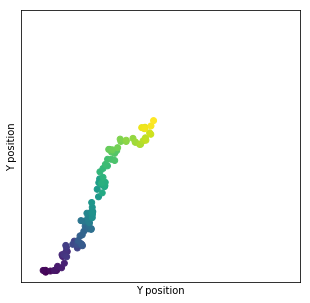

In [20]:
gs = gridspec.GridSpec(2, 2)
fig1 = plt.figure(figsize=(5, 5))
ax1 = fig1.gca()

ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
ax1.set_xlim([0, 100])
ax1.set_ylim([0, 100])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('Y position')
ax1.set_xlabel('Y position')

Text(0,0.5,'Δy')

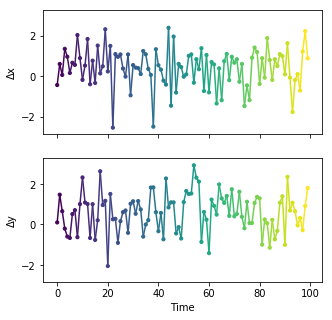

In [21]:
fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
dx_lc.set_array(np.arange(T - 1))
ax2.add_collection(dx_lc)
ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
#ax2.set_xlabel('t')
ax2.set_ylabel('Δx')

dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
dy_lc.set_array(np.arange(T-1))
ax3.add_collection(dy_lc)
ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
ax3.set_xlabel('Time')
ax3.set_ylabel('Δy')

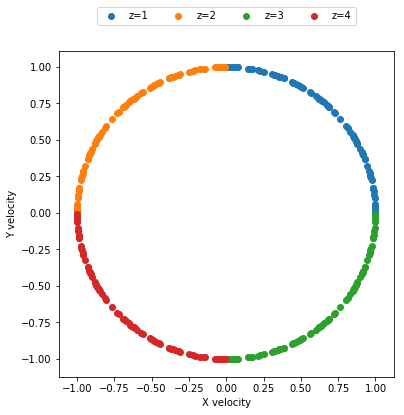

In [22]:
v = np.random.random((100, 2))
v_norm = ((v**2).sum(1))**0.5
v = v / v_norm[:, None]
v = v[v_norm < 1]
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()
ax.scatter(v[:,0], v[:,1], label='z=1')
ax.scatter(-v[:,0], v[:,1], label='z=2')
ax.scatter(v[:,0], -v[:,1], label='z=3')
ax.scatter(-v[:,0], -v[:,1], label='z=4')
ax.set_xlabel('X velocity')
ax.set_ylabel('Y velocity')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
